## Import Pythonic Libraries
This notebook should be run at [swan.cern.ch](swan.cern.ch).  The notebook parameters used are:
- Python 3
- Software stack: 97
- Platform: CentOS 7 (gcc9)
- Number of cores: 2 or 4
- Memory: 8 or 10 GB

Requires downloading `root` samples (within a directory) to the working directory hosting this notebook.

In [1]:
import os, sys
import mplhep as hep
import seaborn as sns
import time
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import auc
import ROOT
import matplotlib.pyplot as plt
import matplotlib.gridspec as gdsc
import ipywidgets as widgets
from ROOT import TMVA, TFile, TTree, TCut, TRandom3
from ROOT import TCanvas, TGraph
from ROOT import gSystem, gApplication, gROOT
import varsList
ROOT.ROOT.EnableImplicitMT()

Welcome to JupyROOT 6.20/02


## Select the samples and variables to compare

In [2]:
# get list of directories in working directory
dirList = next(os.walk(os.getcwd()))[1]

# root paths
treeName = "ljmet"

In [3]:
print("Choose the first sample directory for comparison:")
sampleDirOne = widgets.Dropdown( options = dirList )
sampleDirOne

Choose the first sample directory for comparison:


Dropdown(options=('.git', '.sys.v#.InputVariables.ipynb', '.sys.v#.Visualize Correlation.ipynb', '.sys.v#.comp…

In [7]:
print("Choose the samples (ctrl + mouse) from {}:".format( sampleDirOne.value ))
sampleOne = widgets.SelectMultiple( options = os.listdir( sampleDirOne.value ) )
sampleOne

Choose the samples (ctrl + mouse) from FWLJMET102X_1lep2017_Oct2019_4t_03202020_step2:


SelectMultiple(options=('TTTT_TuneCP5_PSweights_13TeV-amcatnlo-pythia8_hadd.root', 'TTTo2L2Nu_TuneCP5_PSweight…

In [8]:
print("Choose the second sample directory for comparison:")
sampleDirTwo = widgets.Dropdown( options = dirList )
sampleDirTwo

Choose the second sample directory for comparison:


Dropdown(options=('.git', '.sys.v#.InputVariables.ipynb', '.sys.v#.Visualize Correlation.ipynb', '.sys.v#.comp…

In [9]:
print("Choose the samples (ctrl + mouse) from {}:".format( sampleDirTwo.value ))
sampleTwo = widgets.SelectMultiple( options = os.listdir( sampleDirTwo.value ) )
sampleTwo

Choose the samples (ctrl + mouse) from FWLJMET102X_1lep2017_Oct2019_4t_05072020_step2:


SelectMultiple(options=('TTTT_TuneCP5_PSweights_13TeV-amcatnlo-pythia8_hadd.root', 'TTTo2L2Nu_TuneCP5_PSweight…

In [10]:
rootFileOne = {}
rootTreeOne = {}
branchListOne = {}
rootFileTwo = {}
rootTreeTwo = {}
branchListTwo = {}

commonBranches = []

for file in sampleOne.value:
    rootFileOne[file] = ROOT.TFile.Open( sampleDirOne.value + "/" + file )
    rootTreeOne[file] = rootFileOne[file].Get( treeName )
    branchListOne[file] = [ branch.GetName() for branch in rootTreeOne[file].GetListOfBranches() ]

for file in sampleTwo.value:
    rootFileTwo[file] = ROOT.TFile.Open( sampleDirTwo.value + "/" + file )
    rootTreeTwo[file] = rootFileTwo[file].Get( treeName )
    branchListTwo[file] = [ branch.GetName() for branch in rootTreeTwo[file].GetListOfBranches() ]

for fileOne in branchListOne:
    for itr, fileTwo in enumerate(branchListTwo):
        commonBranch = set(branchListOne[fileOne]).intersection(branchListTwo[fileTwo])
        if itr == 0:
            commonBranches = commonBranch
        else:
            commonBranches = commonBranches.intersection(commonBranch)
        
    
print("{} variables shared.".format(
    len(commonBranches)
))

382 variables shared.


### Combine the root files

In [11]:
# get relevant cuts from each root file
cutOne = {}
cutTwo = {}

startTime = time.time()

for file in sampleOne.value:
    cutOne[file] = np.asarray(rootTreeOne[file].AsMatrix( [
        "leptonPt_MultiLepCalc",
        "isElectron",
        "isMuon",
        "corr_met_MultiLepCalc",
        "MT_lepMet",
        "minDR_lepJet",
        "AK4HT",
        "DataPastTriggerX",
        "MCPastTriggerX",
        "NJetsCSVwithSF_MultiLepCalc",
        "NJets_JetSubCalc",
        "triggerXSF",
        "pileupWeight",
        "lepIdSF",
        "EGammaGsfSF",
        "isoSF",
        "L1NonPrefiringProb_CommonCalc",
        "xsecEff",
        "MCWeight_MultiLepCalc"
    ] ))
    
print("Finished loading first sample(s) in {:.2f} seconds".format(time.time()-startTime))

for file in sampleTwo.value:
    cutTwo[file] = np.asarray(rootTreeTwo[file].AsMatrix( [
        "leptonPt_MultiLepCalc",
        "isElectron",
        "isMuon",
        "corr_met_MultiLepCalc",
        "MT_lepMet",
        "minDR_lepJet",
        "AK4HT",
        "DataPastTriggerX",
        "MCPastTriggerX",
        "NJetsCSVwithSF_MultiLepCalc",
        "NJets_JetSubCalc",
        "triggerXSF",
        "pileupWeight",
        "lepIdSF",
        "EGammaGsfSF",
        "isoSF",
        "L1NonPrefiringProb_CommonCalc",
        "xsecEff",
        "MCWeight_MultiLepCalc"
    ] ))
    
print("Finished loading second sample(s) in {:.2f} seconds".format(time.time()-startTime))

/cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc8-opt/lib/ROOT.py:352: FutureWarning: Instantiating a function template with parentheses ( f(type1, ..., typeN) ) is deprecated and will not be supported in a future version of ROOT. Instead, use square brackets: f[type1, ..., typeN]
  flat_matrix_ptr = _root.ROOT.Internal.RDF.GetVectorAddress(dtype)(flat_matrix)


Finished loading first sample(s) in 48.19 seconds
Finished loading second sample(s) in 70.74 seconds


In [12]:
cutOneComb = np.concatenate([cutOne[file] for file in sampleOne.value])
cutTwoComb = np.concatenate([cutTwo[file] for file in sampleTwo.value])

cutOneSort = np.asarray(cutOneComb[cutOneComb[:,0].argsort()])
cutTwoSort = np.asarray(cutTwoComb[cutTwoComb[:,0].argsort()])

In [13]:
cutOneSort = cutOneComb[np.lexsort((cutOneComb[:,3],cutOneComb[:,0]))]
cutTwoSort = cutTwoComb[np.lexsort((cutTwoComb[:,3],cutTwoComb[:,0]))]

##### Apply selection to the events and evaluate weights

In [14]:
# apply cuts
leptonPt = 50.
isElectron = 1
isMuon = 1
corr_met = 60.
MT_lepMet = 60.
minDR_lepJet = 0.4
AK4HT = 510.
DataPastTriggerX = 1
MCPastTriggerX = 1
bJets= 2
nJets = 6

cutMaskOne = np.zeros(np.shape(cutOneSort)[0])
cutMaskTwo = np.zeros(np.shape(cutTwoSort)[0])
weightOne = np.full(np.shape(cutOneSort)[0],1.0)
weightTwo = np.full(np.shape(cutTwoSort)[0],1.0)
startTime = time.time()
for i in range(np.shape(cutOneComb)[0]):
    if ( ( cutOneSort[i,0] > leptonPt and cutOneSort[i,1] == isElectron ) or ( cutOneSort[i,0] > leptonPt and cutOneSort[i,2] == isMuon ) ):
        if ( cutOneSort[i,3] > corr_met and cutOneSort[i,4] > MT_lepMet and cutOneSort[i,5] > minDR_lepJet and cutOneSort[i,6] > AK4HT ):
            if ( int(cutOneSort[i,7]) == DataPastTriggerX and int(cutOneSort[i,8]) == MCPastTriggerX ):
                if ( int(cutOneSort[i,9]) >= bJets and int(cutOneSort[i,10]) >= nJets ):
                    cutMaskOne[i] = 1
    weightOne[i] = np.prod(cutOneSort[i,11:]) / abs(cutOneSort[i,18])
            
print("{} events out of {} passed for sample(s) one...".format(int(np.sum(cutMaskOne)),np.shape(cutOneComb)[0]))
for i in range(np.shape(cutTwoComb)[0]):
    if ( ( cutTwoSort[i,0] > leptonPt and cutTwoSort[i,1] == isElectron ) or ( cutTwoSort[i,0] > leptonPt and cutTwoSort[i,2] == isMuon ) ):
        if ( cutTwoSort[i,3] > corr_met and cutTwoSort[i,4] > MT_lepMet and float(cutTwoSort[i,5]) > minDR_lepJet and cutTwoSort[i,6] > AK4HT ):
            if ( int(cutTwoSort[i,7]) == DataPastTriggerX and int(cutTwoSort[i,8]) == MCPastTriggerX ):
                if ( int(cutTwoSort[i,9]) >= bJets and int(cutTwoSort[i,10]) >= nJets ):
                    cutMaskTwo[i] = 1
    weightTwo[i] = np.prod(cutTwoSort[i,11:]) / abs(cutTwoSort[i,18])
                    
print("{} events out of {} passed for sample(s) two...".format(int(np.sum(cutMaskTwo)),np.shape(cutTwoComb)[0]))
print("Finished after {:.2f} seconds".format(time.time()-startTime))

101397 events out of 434191 passed for sample(s) one...
101397 events out of 434191 passed for sample(s) two...
Finished after 6.66 seconds


##### Visualize the weights

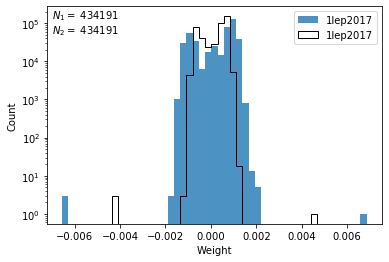

In [15]:
bins = np.linspace(min(min(weightOne),min(weightTwo)),max(max(weightOne),max(weightTwo)),50)
plt.close()
plt.figure()
plt.hist(
    weightOne, bins=bins, label=sampleDirOne.value.split("_")[1],
    histtype="stepfilled",alpha=0.8
)
plt.hist(
    weightTwo, bins=bins, label=sampleDirTwo.value.split("_")[1],
    histtype="step",color="black"
)
plt.annotate(
    u"$N_1=$ {}".format( len( weightOne ) ),
    xycoords = "axes pixels",
    xy = (5,205)
)
plt.annotate(
    u"$N_2=$ {}".format( len( weightTwo ) ),
    xycoords = "axes pixels",
    xy = (5,190)
)
plt.ylabel("Count")
plt.xlabel("Weight")
plt.legend(loc="best")
plt.yscale("log")
plt.show()

### Apply the selection mask to the desired input variable

In [16]:
print("Choose the variable to compare:")
fileList = widgets.Dropdown( options = sorted(commonBranches) )
fileList

Choose the variable to compare:


Dropdown(options=('AK4HT', 'AK4HTpMETpLepPt', 'AK4JetBTag_MultiLepCalc_PtOrdered', 'AK4JetDeepCSVb_MultiLepCal…

In [17]:
# define some plotting parameters
minBin = 0
maxBin = 4000
nBins = 101
binWidth = float( maxBin - minBin ) / float(nBins)
if len(sampleOne.value) < 2:
    sampleType = "Signal"
else:
    sampleType = "Background"

histBins = np.linspace(minBin, maxBin, nBins)

In [18]:
# populate the branches
branchOne = {}
branchTwo = {}

startTime = time.time()
# want to sort these by a similar variable (i.e. leptonpt_multilepcalc) because root doesn't load in the data in the correct order so necessary to sort
for file in sampleOne.value:
    branchOne[file] = np.asarray(rootTreeOne[file].AsMatrix( [ "leptonPt_MultiLepCalc", "corr_met_MultiLepCalc", str(fileList.value) ] ))
for file in sampleTwo.value:
    branchTwo[file] = np.asarray(rootTreeTwo[file].AsMatrix( [ "leptonPt_MultiLepCalc", "corr_met_MultiLepCalc", str(fileList.value) ] ))

branchOneComb = np.concatenate([branchOne[file] for file in sampleOne.value])
branchTwoComb = np.concatenate([branchTwo[file] for file in sampleTwo.value])

branchOneSort = branchOneComb[np.lexsort((branchOneComb[:,1],branchOneComb[:,0]))][:,2]
branchTwoSort = branchTwoComb[np.lexsort((branchTwoComb[:,1],branchTwoComb[:,0]))][:,2]

branchCutOne = branchOneSort[cutMaskOne.astype(bool)]
branchCutTwo = branchTwoSort[cutMaskTwo.astype(bool)]

weightCutOne = weightOne[cutMaskOne.astype(bool)]
weightCutTwo = weightTwo[cutMaskTwo.astype(bool)]

print("Finished applying selection to input variables in {:.2f} seconds...".format(time.time()-startTime))

Finished applying selection to input variables in 6.50 seconds...


### Populate histograms with weighting

Pre-selection histogram

In [19]:
histWgtOne = np.zeros(nBins)
histErrOne = [ [0] for _ in range(nBins) ]
histWgtTwo = np.zeros(nBins)
histErrTwo = [ [0] for _ in range(nBins) ]
startTime = time.time()

excludedOne = 0
excludedTwo = 0

for i, event in enumerate(branchOneSort):
    if ( event >= minBin ) and ( event <= maxBin ):
        index = np.argwhere( histBins >= event ).flatten()[0]
        histWgtOne[index] += weightOne[i]
        histErrOne[index].append(weightOne[i]**2.)
    else:
        excludedOne += 1
print("{} events excluded from sample one with binning: ({},{},{})".format(
    excludedOne,
    minBin,
    maxBin,
    nBins
))
    
for i, event in enumerate(branchTwoSort):
    if ( event >= minBin ) and ( event < maxBin ):
        index = np.argwhere( histBins >= event ).flatten()[0]
        histWgtTwo[index] += weightTwo[i]
        histErrTwo[index].append(weightTwo[i]**2.)
    else:
        excludedTwo += 1
print("{} events excluded from sample two with binning: ({},{},{})".format(
    excludedTwo,
    minBin,
    maxBin,
    nBins
))
            
histErrOne = np.array([np.sqrt(np.sum(i)) for i in histErrOne])
histErrTwo = np.array([np.sqrt(np.sum(i)) for i in histErrTwo])

print("Finished binning in {:.2f} seconds".format(time.time()-startTime))

71 events excluded from sample one with binning: (0,4000,101)
71 events excluded from sample two with binning: (0,4000,101)
Finished binning in 17.74 seconds


Post-selection histogram

In [20]:
histWgtCutOne = np.zeros(nBins)
histWgtErrOne = [ [] for _ in range(nBins) ]
histWgtCutTwo = np.zeros(nBins)
histWgtErrTwo = [ [] for _ in range(nBins) ]
startTime = time.time()

excludedOne = 0
excludedTwo = 0

for i, event in enumerate(branchCutOne):
    if ( event >= minBin ) and ( event <= maxBin ):
        index = np.argwhere( histBins >= event ).flatten()[0]
        histWgtCutOne[index] += weightCutOne[i]
        histWgtErrOne[index].append(weightCutOne[i]**2.)
    else:
        excludedOne += 1
print("{} events excluded from sample one with binning: ({},{},{})".format(
    excludedOne,
    minBin,
    maxBin,
    nBins
))

for i, event in enumerate(branchCutTwo):
    if ( event >= minBin ) and ( event <= maxBin ):
        index = np.argwhere( histBins >= event ).flatten()[0]
        histWgtCutTwo[index] += weightCutTwo[i]
        histWgtErrTwo[index].append(weightCutTwo[i]**2.)
    else:
        excludedTwo += 1
print("{} events excluded from sample one with binning: ({},{},{})".format(
    excludedTwo,
    minBin,
    maxBin,
    nBins
))


histWgtErrOne = np.array([np.sqrt(np.sum(i)) for i in histWgtErrOne])
histWgtErrTwo = np.array([np.sqrt(np.sum(i)) for i in histWgtErrTwo])
            
print("Finished binning in {:.2f} seconds".format(time.time()-startTime))

16 events excluded from sample one with binning: (0,4000,101)
16 events excluded from sample one with binning: (0,4000,101)
Finished binning in 4.19 seconds


## Plot the two distributions
The (two sample) Kolmogorov-Smirnov test is used to evaluate if the two input distributions are sampled from the same parent population. Two metrics are provided: the Kolmogrov-Smirnov statistic ($D$) and the $p$-value.  $D$ represents a determinant which determines whether the null hypothesis of being similarly sampled is rejected,
$$D_{n,m}>c(\alpha)\sqrt{\frac{n+m}{n\times m}}$$
where $c(\alpha)$ is given by,
$$c(\alpha)=\sqrt{-\ln(\frac{\alpha}{2})\times \frac{1}{2}}$$
and $n$ and $m$ are the sizes of the respective distributions.

The $p$-value is evaluated by whether it is above or below the set $\alpha$.  That is, if $p>\alpha$, then the null hypothesis is not rejected.  Thus, either $D$ or $p$ can be used in evaluating the similarity of the distributions.

#### Define some methods for plotting

In [21]:
def ratio_error(a, err_a, b, err_b):
# propagates error for the ratio a / b
    term1 = err_a / b
    term2 = a * err_b / ( b**2 )
    return np.sqrt(term1**2+term2**2)

def get_hist_ratio(hist1, err1, hist2, err2):
# returns two arrays: an array of ratios between hist1 and hist2 and their association (Poissonian) uncertainty
    if len(hist1) == len(hist2):
        nBins = len(hist1)
        ratioHist  = np.zeros(nBins)
        ratioError = np.zeros(nBins)
        # populate the ratio and error
        for i in range(nBins):
            if ( hist1[i] != 0 and hist2[i] != 0 ):
                ratioHist[i] = ( hist1[i] / hist2[i] )
                ratioError[i] = ratio_error(hist1[i],err1[i],hist2[i],err2[i])
        return ratioHist, ratioError
    else: 
        print("Hist 1 and Hist 2 do not have the same length.")

def get_ks(hist1,hist2):
    mask = ( hist1 != 0 ) & ( hist2 != 0 )
    mask_start = np.argwhere(mask==True).flatten()[0]
    mask_end = np.argwhere(mask==True).flatten()[-1]
    hist1Filt = hist1[mask_start:mask_end]
    hist2Filt = hist2[mask_start:mask_end]
    D, pVal = stats.ks_2samp(hist1Filt, hist2Filt)
    return D, pVal
        
def plot_hist(hist1, label1, hist2, label2, bins, key, log, density, savePath):
    plt.rc("axes", axisbelow = True)
    plt.figure( figsize = ( 12, 12 ) )
    gdsc.GridSpec(12,10)
    plt.subplot2grid((12,10), (0,0), colspan=12, rowspan=7)
    plt.title( "{} {} {}".format( sampleType, fileList.value, key ) )
    histOne, binsOne, _ = plt.hist( hist1, label = label1, histtype = "step", color = "green", linewidth = 2, alpha = 1.0, bins = bins, density = density )
    errOne = np.array([ np.sqrt(i) for i in histOne ])
    plt.fill_between( binsOne[:-1] + 0.5*binWidth, histOne + errOne, histOne - errOne, step = "mid", color = "green", alpha = 0.3, linewidth = 0 )
    histTwo, binsTwo, _ = plt.hist(
        hist2, label = label2, histtype = "step", color = "black", linewidth=2, bins = bins, density = density
    )
    errTwo = np.array( [np.sqrt(i) for i in histTwo ])
    plt.errorbar( binsTwo[:-1] + 0.5*binWidth, histTwo, yerr=errTwo, linestyle = "none", capsize = 0., color = "black" )
    # annotate with statistics
    D, pVal = get_ks(histOne, histTwo)
    plt.annotate(
        u"$N_1=$ {:.2f}".format( sum(histOne) ),
        xycoords = "axes pixels",
        xy = (5,425)
    )
    plt.annotate(
        u"$N_2=$ {:.2f}".format( sum(histTwo) ),
        xycoords = "axes pixels",
        xy = (5,410)
    )
    plt.annotate(
        u"$D=$ {:.4f}".format( D ),
        xycoords = "axes pixels",
        xy = (100,425)
    )
    plt.annotate(
        u"$p=$ {:.4e}".format( pVal ),
        xycoords = "axes pixels",
        xy = (100, 410)
    )
    
    # label the upper plot 
    if density:
        plt.ylabel( "Normalized Count" )
    else: plt.ylabel( "Count" )
    
    plt.xlim(minBin - binWidth, maxBin + binWidth)
    if log:
        plt.yscale("log")
    else:
        plt.ylim(0,1.2*max(max(histOne),max(histTwo)))
    plt.legend( loc = "best" )
    plt.grid( which = "major", linestyle = "--" )
    plt.grid( which = "minor", linestyle = ":")
    plt.minorticks_on()
    
    # populate the lower ratio plot
    ratioHist, ratioError = get_hist_ratio(histOne,errOne,histTwo,errTwo)
    
    plt.subplot2grid((12,10), (7,0), colspan=10, rowspan=3)
    plt.errorbar( bins[:-1], ratioHist, yerr=ratioError, linestyle="none", capsize=3., marker="o",color="black",markerfacecolor="white" )

    plt.xlabel( str(fileList.value) )
    plt.ylabel( "Normalized Hist 1 / Hist 2" )
    plt.xlim( minBin - binWidth, maxBin + binWidth)
    plt.ylim(-1,3.0)

    plt.grid( which = "major", linestyle = "--" )
    plt.tight_layout()
    
    if len(savePath) > 0:
        plt.savefig("{}/{} {} ({}j).png".format(savePath,sampleType,str(fileList.value),str(nJets)))
    plt.show()
    
def plot_weighted_hist(hist1, err1, label1, hist2, err2, label2, bins, key, density, savePath):
    # evaluate the normalization
    if density:
        norm1 = auc(bins,hist1)
        norm2 = auc(bins,hist2)
    else:
        norm1 = 1
        norm2 = 1

    plt.rc("axes", axisbelow = True)
    plt.figure( figsize = (12,12) )
    gdsc.GridSpec(12,10)
    
    # populate the upper plot
    plt.subplot2grid((12,10), (0,0), colspan=12, rowspan=7)
    plt.title(r"{} {} {}".format(sampleType,fileList.value,key))
    plt.plot( bins, hist1 / norm1, linestyle="none",marker="o", alpha=0.8,color="green", label=label1 )
    plt.fill_between( bins, (hist1 - err1) / norm1, (hist1 + err1) / norm1, color="green", alpha=0.3, linewidth=0, step="mid" )
    plt.errorbar( bins, hist2 / norm2, yerr = err2 / norm2 , ecolor="black", capsize=3., linestyle="none", marker="o", markerfacecolor="white", markeredgecolor="black", alpha=0.8, label=label2 )
    
    
    D, pVal = get_ks(hist1, hist2)

    plt.annotate(
        u"$N_1=$ {:.2f}".format( sum(hist1) ),
        xycoords = "axes pixels",
        xy = (5,425)
    )
    plt.annotate(
        u"$N_2=$ {:.2f}".format( sum(hist2) ),
        xycoords = "axes pixels",
        xy = (5,410)
    )
    plt.annotate(
        u"$D=$ {:.4f}".format( D ),
        xycoords = "axes pixels",
        xy = (100,425)
    )
    plt.annotate(
        u"$p=$ {:.4e}".format( pVal ),
        xycoords = "axes pixels",
        xy = (100, 410)
    )
    if density:
        plt.ylabel("Normalized Count")
    else: plt.ylabel("Count")

    plt.xlim( minBin - binWidth, maxBin + binWidth )
    plt.ylim(0,1.2*max(max(hist1/norm1),max(hist2/norm2)))
    plt.legend( loc = "best" )
    plt.grid( which = "major", linestyle = "--" )
    plt.grid( which = "minor", linestyle = ":")
    plt.minorticks_on()

    # calculate ratio between histograms
    ratioHist, ratioError = get_hist_ratio(hist1/norm1,err1/norm1,hist2/norm2,err2/norm2)

    # plot the ratio histogram in the lower section of the grid        
    plt.subplot2grid((12,10), (7,0), colspan=10, rowspan=3)
    plt.errorbar( bins, ratioHist, yerr=ratioError, linestyle="none", capsize=3., marker="o", color="black", markerfacecolor="white" )

    plt.xlabel( str(fileList.value) )
    plt.ylabel( "Normalized Hist 1 / Hist 2" )
    plt.xlim( minBin - binWidth, maxBin + binWidth)
    plt.ylim(-1,3.0)
    plt.grid( which = "major", linestyle = "--" )
    plt.tight_layout()
    if savePath != "":
        plt.savefig("{}/{} {}({}j).png".format(savePath,sampleType,str(fileList.value),str(nJets)))
    plt.show()

### Plot the pre-selection distribution without weights

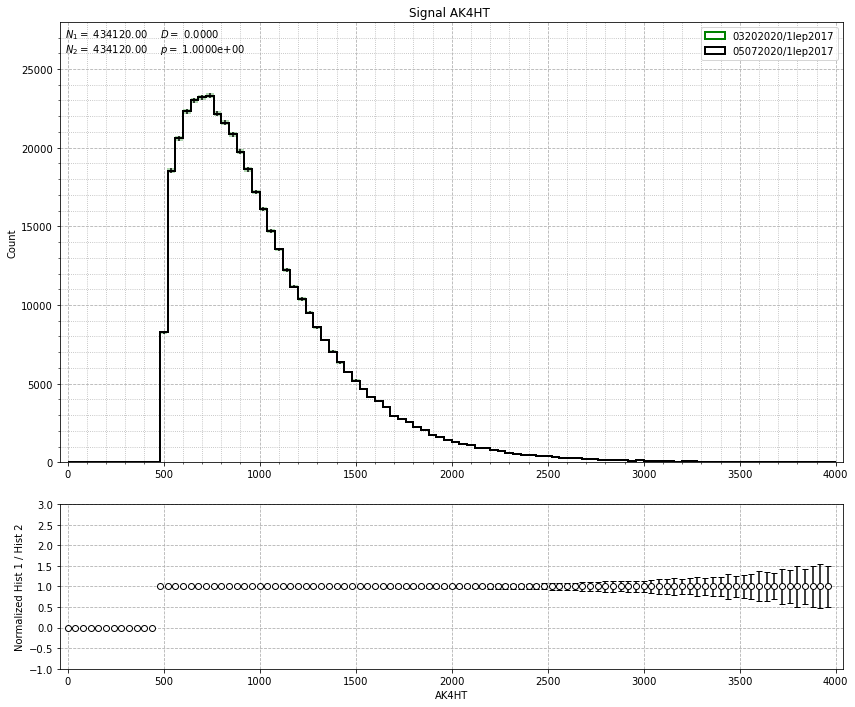

In [22]:
# plot the entire sample collection (i.e. pre-selection) without weights
plot_hist(
    branchOneSort,sampleDirOne.value.split("_")[4]+"/"+sampleDirOne.value.split("_")[1],
    branchTwoSort,sampleDirTwo.value.split("_")[4]+"/"+sampleDirTwo.value.split("_")[1],
    histBins,"",False,False,""
)

### Plot the pre-selection distributions with weights

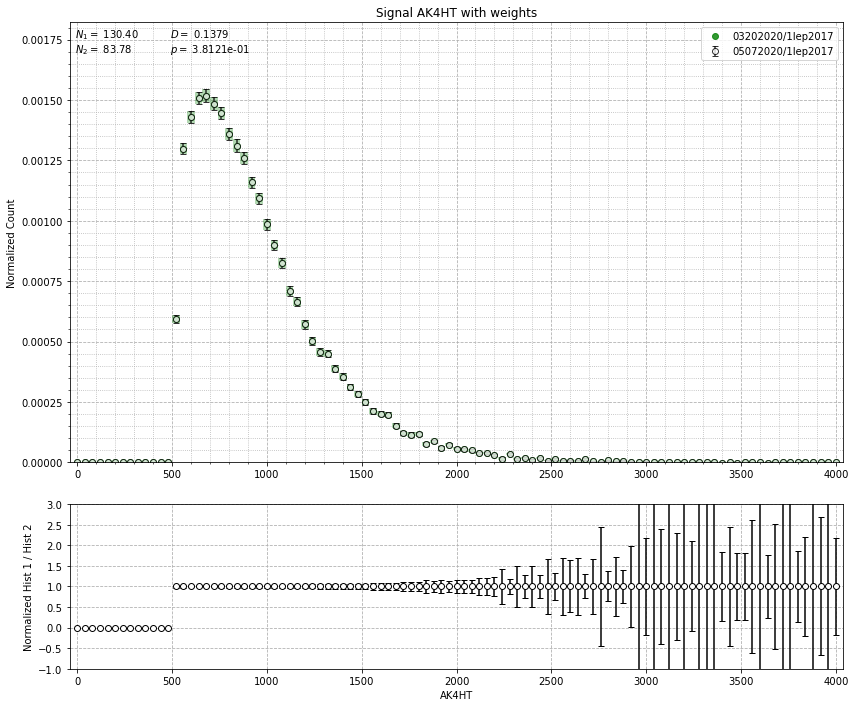

In [23]:
plot_weighted_hist(
    histWgtOne, histErrOne, sampleDirOne.value.split("_")[4]+"/"+sampleDirOne.value.split("_")[1],
    histWgtTwo, histErrTwo, sampleDirTwo.value.split("_")[4]+"/"+sampleDirTwo.value.split("_")[1],
    histBins, "with weights", True, ""
)

### Plot the histograms after selection

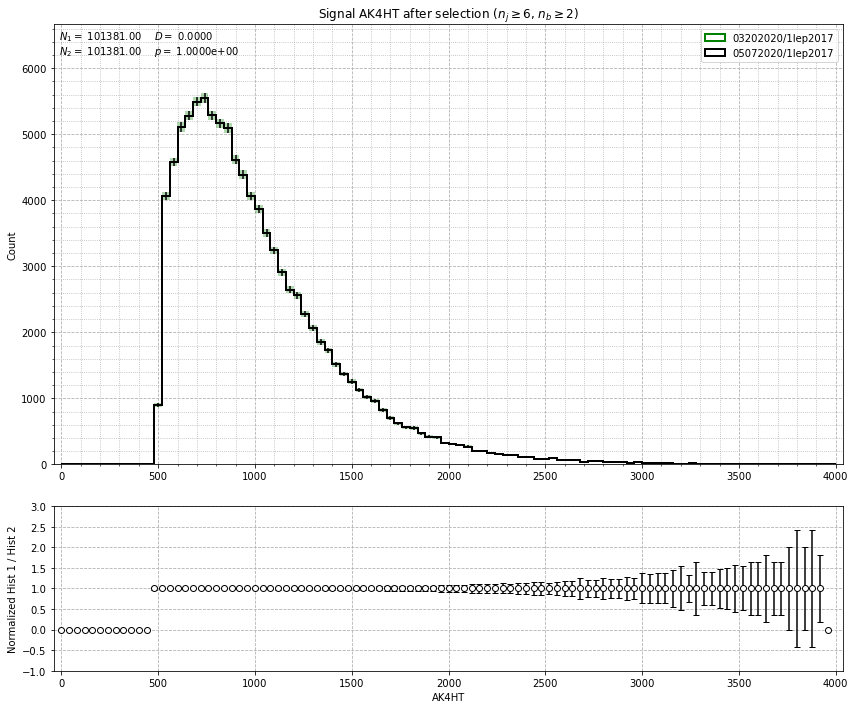

In [24]:
plot_hist(
    branchCutOne,sampleDirOne.value.split("_")[4]+"/"+sampleDirOne.value.split("_")[1],
    branchCutTwo,sampleDirTwo.value.split("_")[4]+"/"+sampleDirTwo.value.split("_")[1],
    histBins,r"after selection ($n_j\geq${}, $n_b\geq${})".format(nJets,bJets),False,False,""
)

### Plot the histograms after selection with weights

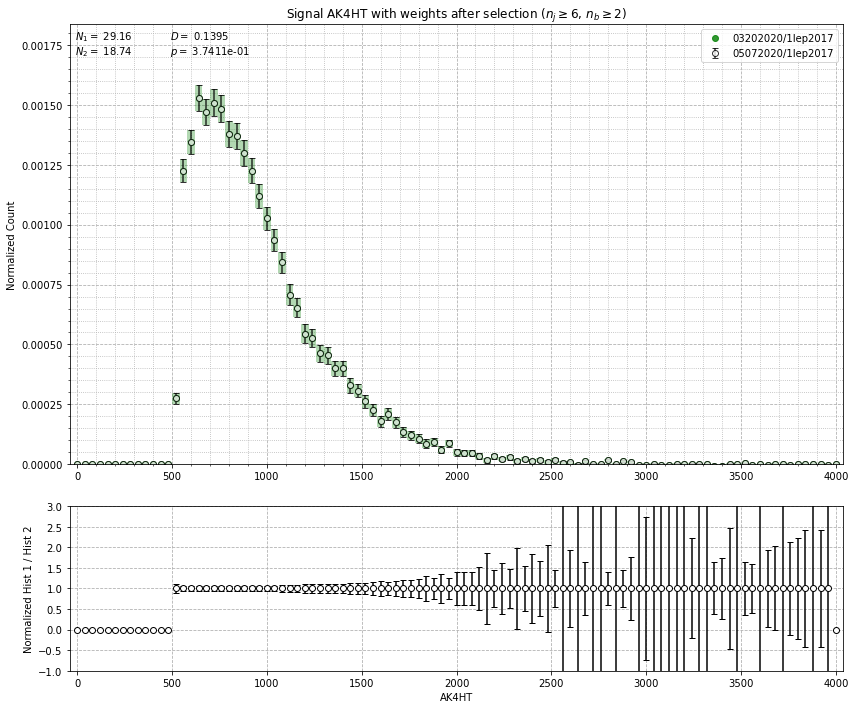

In [25]:
plot_weighted_hist(
    histWgtCutOne, histWgtErrOne, sampleDirOne.value.split("_")[4]+"/"+sampleDirOne.value.split("_")[1],
    histWgtCutTwo, histWgtErrTwo, sampleDirTwo.value.split("_")[4]+"/"+sampleDirTwo.value.split("_")[1],
    histBins, r"with weights after selection ($n_j\geq${}, $n_b\geq${})".format(nJets,bJets), True, ""
)

### Plot the correlation matrix

In [26]:
# populate the branches
histOne = {}
histTwo = {}
varList = np.asarray(varsList.varList["DNN"])[:,0]

indxOne = np.argwhere(varList == "leptonPt_MultiLepCalc")[0,0]
indxTwo = np.argwhere(varList == "corr_met_MultiLepCalc")[0,0]

startTime = time.time()
# want to sort these by a similar variable (i.e. leptonpt_multilepcalc) because root doesn't load in the data in the correct order so necessary to sort
for file in sampleOne.value:
    histOne[file] = np.asarray(rootTreeOne[file].AsMatrix( varList ))
for file in sampleTwo.value:
    histTwo[file] = np.asarray(rootTreeTwo[file].AsMatrix( varList ))

In [27]:
histOneComb = np.concatenate([histOne[file] for file in sampleOne.value])
histTwoComb = np.concatenate([histTwo[file] for file in sampleTwo.value])

histOneSort = histOneComb[np.lexsort((histOneComb[:,indxTwo],histOneComb[:,indxOne]))]
histTwoSort = histTwoComb[np.lexsort((histTwoComb[:,indxTwo],histTwoComb[:,indxOne]))]

histCutOne = histOneSort[cutMaskOne.astype(bool)]
histCutTwo = histTwoSort[cutMaskTwo.astype(bool)]

print("Finished applying selection to input variables in {:.2f} seconds...".format(time.time()-startTime))

Finished applying selection to input variables in 358.88 seconds...


In [28]:
pdCutOne = pd.DataFrame(histCutOne,columns = varList)
pdCutTwo = pd.DataFrame(histCutTwo,columns = varList)

In [29]:
startTime = time.time()
pdCorrOne = pdCutOne.corr()
pdCorrTwo = pdCutTwo.corr()
print("Finished evaluating in {} seconds".format(time.time()-startTime))

Finished evaluating in 32.64385199546814 seconds


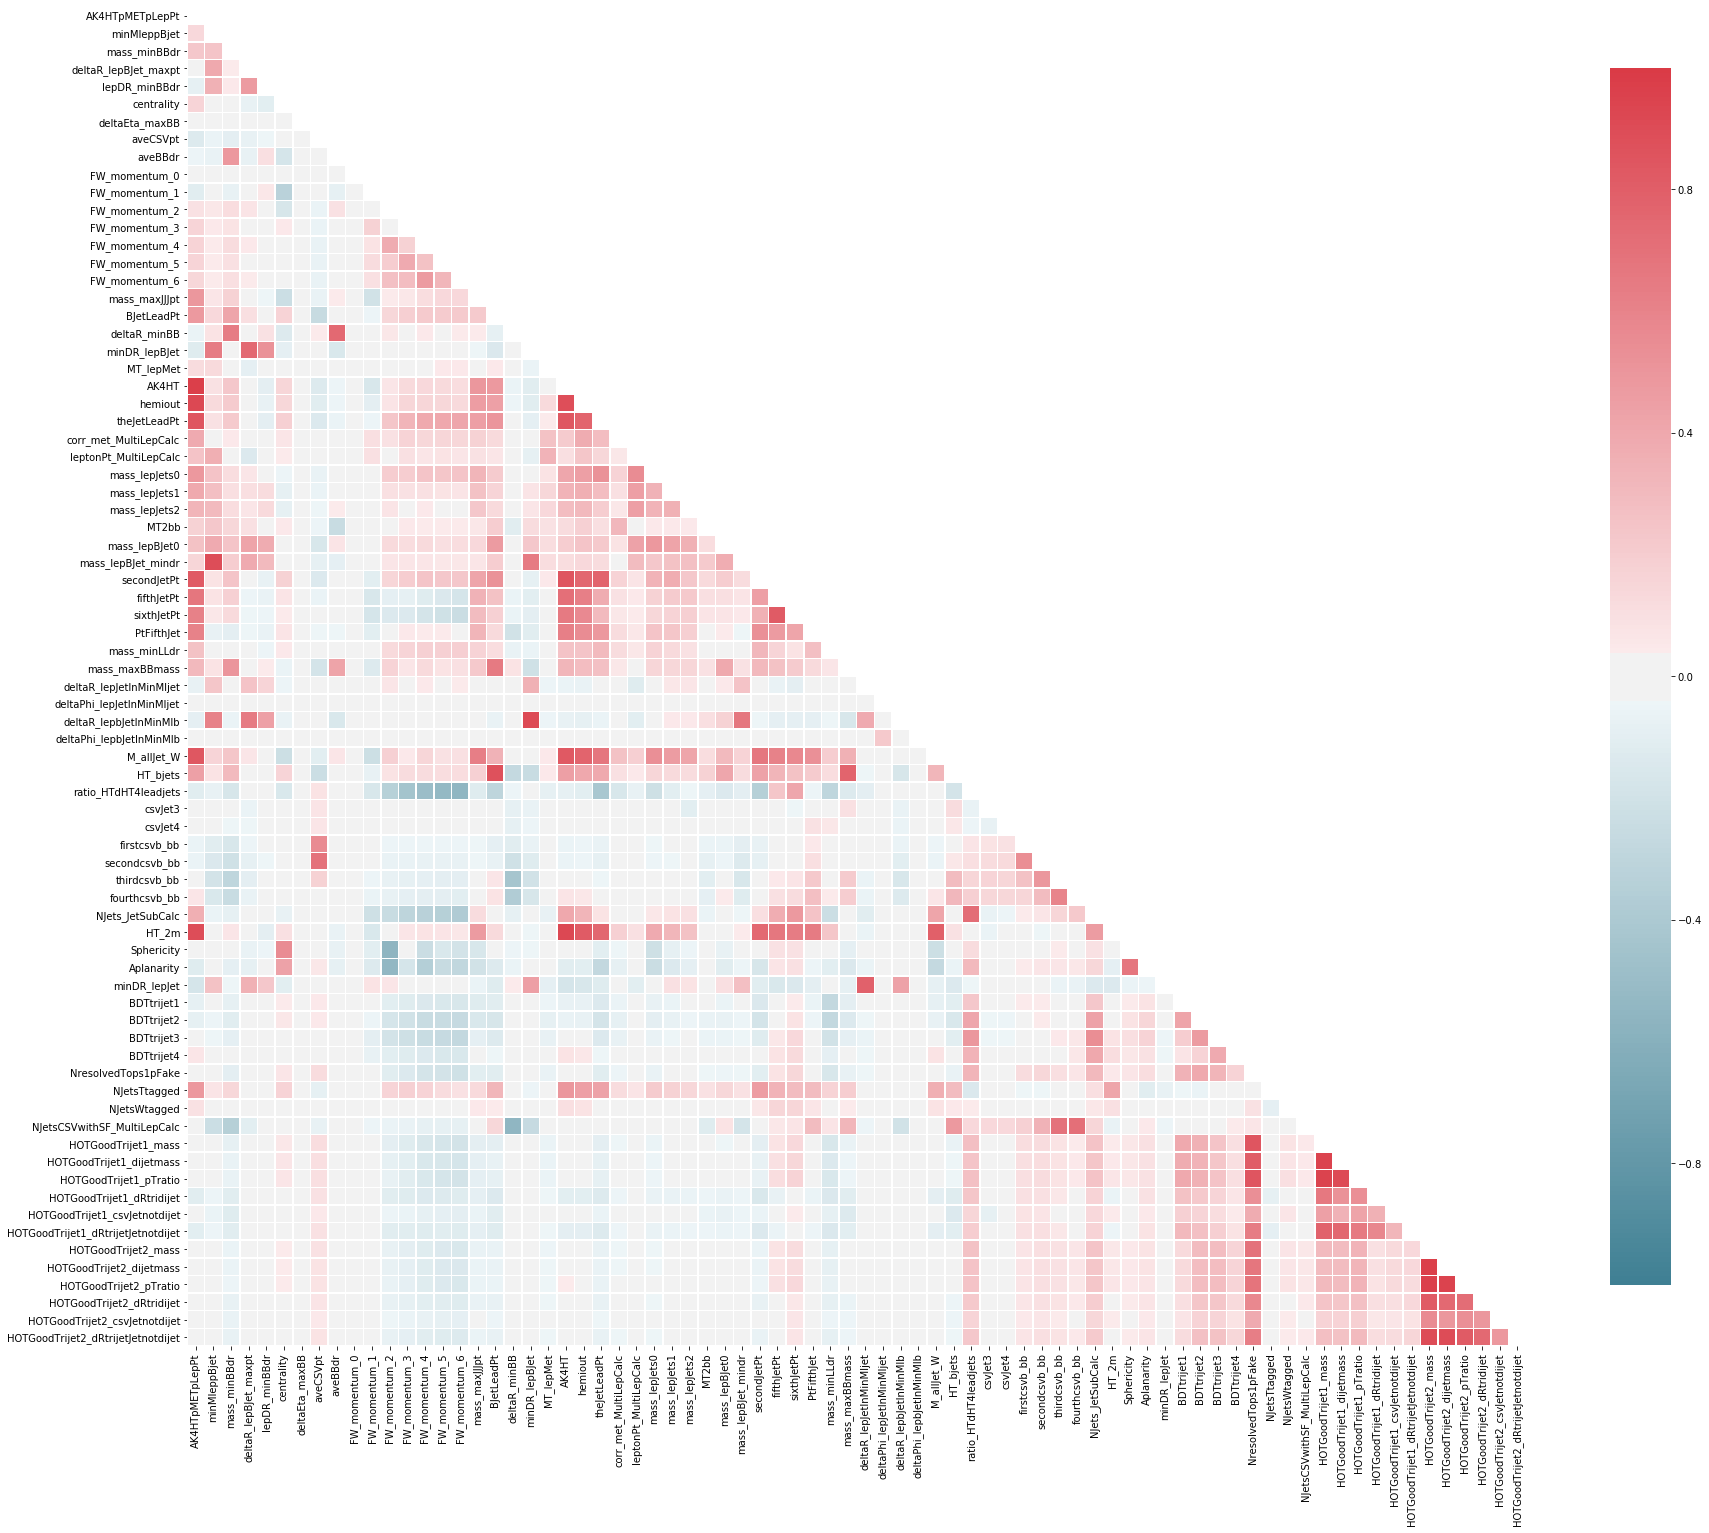

In [30]:
mask = np.triu(np.ones_like(pdCorrOne, dtype=np.bool))
f,ax = plt.subplots(figsize=(30,28))
ax = sns.heatmap(
    pdCorrOne,
    mask=mask,
    vmin=-1, vmax=1, center=0,
    cmap = sns.diverging_palette(220, 10, as_cmap=True),
    square=True,
    linewidth=.5,
    cbar_kws={"shrink":.8}
)